<a href="https://colab.research.google.com/github/mrdbourke/pytorch-resnet-twitch/blob/main/resnet50_twitch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Mon Jan 10 01:46:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [67]:
!pip install torchinfo
import torchinfo
import os

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch import nn
from torch.utils.data import Dataset, DataLoader 

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Data loading

Let's import CIFAR10 to build a ResNet50 model on to fit.

In [10]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Setup transform to preprocess images
transform = transforms.Compose(
    [transforms.ToTensor(),
     # Normalize to 0.5 mean and 0.5 std across all 3 colour channels of images
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

# Load training data
train_data = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE,
                              # num workers defines how many CPU cores to use to load data
                              # usually more is better... though you may jam your machine if you use too much...
                              shuffle=True, num_workers=NUM_WORKERS)

# Load testing data
test_data = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [12]:
class_names = train_data.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

[15593]
torch.Size([3, 32, 32])
torch.Size([32, 32, 3])


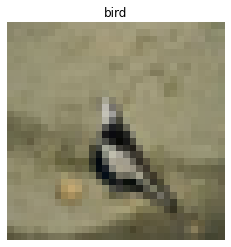

In [39]:
import random
import matplotlib.pyplot as plt
random_idx = random.sample(list(range(len(train_data))), k=1)
print(random_idx)
image, label = train_data[random_idx[0]]
print(image.shape)
image = image.permute(1, 2, 0) / 2 + 0.5 # change image axis order (3, 32, 32) -> (32, 32, 3) & unormalize
print(image.shape)
plt.imshow(image)
plt.title(class_names[label])
plt.axis(False);

## Build the model

We're going to be replicating the ResNet50 model from the classic "Deep Residual Learning for Image Recognition" paper: https://arxiv.org/pdf/1512.03385.pdf

Good implementation here: https://gist.github.com/nikogamulin/7774e0e3988305a78fd73e1c4364aded

In [175]:
class ResNetBlock(nn.Module):
  def __init__(self, in_features, out_features, stride_size=2, is_identity=True):
    super().__init__()
    self.is_identity = is_identity
    self.expansion = 4 # how much to multiply the output channel by (e.g. 64 -> 256, 128 -> 512)
    self.conv1 = nn.Conv2d(in_channels=in_features, 
                           out_channels=out_features,
                           kernel_size=1,
                           stride=1,
                           padding=1)

    self.batch_norm1 = nn.BatchNorm2d(out_features)

    self.conv2 = nn.Conv2d(in_channels=out_features, 
                            out_channels=out_features, 
                            kernel_size=3,
                            stride=2, # middle (3x3 has the increased stride)
                            padding=1)

    self.batch_norm2 = nn.BatchNorm2d(out_features)

    # Increase out features for last layer in block
    increased_out_features = out_features * self.expansion

    self.conv3 = nn.Conv2d(in_channels=out_features,
                           out_channels=increased_out_features,
                           kernel_size=1,
                           stride=1,
                           padding=0)

    self.batch_norm3 = nn.BatchNorm2d(increased_out_features)

    self.relu = nn.ReLU(inplace=True)

    self.identity_downsample = nn.Sequential(nn.Conv2d(in_channels=out_features,
                                                       out_channels=increased_out_features,
                                                       kernel_size=1,
                                                       stride=2,
                                                       padding=1),
                                             nn.BatchNorm2d(increased_out_features))

  def forward(self, x):
    identity = x
    print(identity.shape)
    print(identity.shape)
    print(self.is_identity)

    # Block 1
    out = self.conv1(x)
    out = self.batch_norm1(out)
    out = self.relu(out)

    # Block 2
    out = self.conv2(out)
    out = self.batch_norm2(out)
    out = self.relu(out)

    # Block 3
    out = self.conv3(out)
    out = self.batch_norm3(out)
    print(f"Out shape: {out.shape}")

    if self.is_identity:
      print("Is identity... downsampling...")
      identity = self.identity_downsample(identity)
      print(f"Identity shape: {identity.shape}")

    out += identity
    out = self.relu(out)

    return out

In [176]:
# Construct the ResNet50 model
model = nn.Sequential()
model.add_module("Conv1", nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3))
model.add_module("BatchNorm1", nn.BatchNorm2d(num_features=64))
model.add_module("ReLU1", nn.ReLU(inplace=True))
model.add_module("MaxPool1", nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
previous_feature_size = 64
for feature_size in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
  print(f"Feature size: {feature_size}")
  if previous_feature_size == feature_size:
    stride_size = 1
    is_identity = False
  else:
    stride_size = 2
    is_identity = True
  print(f"Stride size: {stride_size}")
  print(f"Is identity? {is_identity}")
  model.add_module(f"{feature_size}_block", 
                   ResNetBlock(in_features=feature_size, 
                               out_features=feature_size, 
                               stride_size=stride_size,
                               is_identity=True))
  previous_feature_size = feature_size
model.add_module("avg_pool", nn.AdaptiveAvgPool2d((1, 1)))
model.add_module("fully_connected", nn.Linear(in_features=previous_feature_size, out_features=len(class_names)))
model.to(device)

Feature size: 64
Stride size: 1
Is identity? False
Feature size: 64
Stride size: 1
Is identity? False
Feature size: 64
Stride size: 1
Is identity? False
Feature size: 128
Stride size: 2
Is identity? True
Feature size: 128
Stride size: 1
Is identity? False
Feature size: 128
Stride size: 1
Is identity? False
Feature size: 128
Stride size: 1
Is identity? False
Feature size: 256
Stride size: 2
Is identity? True
Feature size: 256
Stride size: 1
Is identity? False
Feature size: 256
Stride size: 1
Is identity? False
Feature size: 256
Stride size: 1
Is identity? False
Feature size: 256
Stride size: 1
Is identity? False
Feature size: 256
Stride size: 1
Is identity? False
Feature size: 512
Stride size: 2
Is identity? True
Feature size: 512
Stride size: 1
Is identity? False
Feature size: 512
Stride size: 1
Is identity? False


Sequential(
  (Conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (BatchNorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (ReLU1): ReLU(inplace=True)
  (MaxPool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (64_block): ResNetBlock(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), padding=(1, 1))
    (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
    (batch_norm3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (identity_downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(2, 2), padding=(1, 1))
  

In [177]:
model(torch.unsqueeze(train_data[0][0].to(device), dim=0))

torch.Size([1, 64, 8, 8])
torch.Size([1, 64, 8, 8])
True
Out shape: torch.Size([1, 256, 5, 5])
Is identity... downsampling...
Identity shape: torch.Size([1, 256, 5, 5])
torch.Size([1, 256, 5, 5])
torch.Size([1, 256, 5, 5])
True


RuntimeError: ignored

In [178]:
from torchinfo import summary
summary(model, input_size=(BATCH_SIZE, 3, 224, 224))

torch.Size([32, 64, 56, 56])
torch.Size([32, 64, 56, 56])
True
Out shape: torch.Size([32, 256, 29, 29])
Is identity... downsampling...
Identity shape: torch.Size([32, 256, 29, 29])
torch.Size([32, 256, 29, 29])
torch.Size([32, 256, 29, 29])
True


RuntimeError: ignored